# Overview

This notebook shows the basic features of the BOCD implementation using synthetic data.

In order to run BOCD, we need
- A *time series model* of type `bocd.TimeSeriesModel`, which is used to make one-step ahead (posterior)
    predictions $p(x_{t}|x_{(t-r_{t}):(t-1)})$ about the current observation $x_{t}$ given the observations at previous time steps $x_{t-r_{t}}, x_{t-(r_{t}-1)}, ..., x_{t-1}=:x_{(t-r_{t}):(t-1)}$, for all possible run lengths $r_{t}=0,1,...,r_{t}^{\left(\mathrm{max}\right)}$. All observations $x_{(t-r_{t}):(t)}$ are thought to be part of the same run length section (or segment).
- A *run length prior distribution* $p(r_{0})$, which represents a discrete probability distribution of the run length at time $t = 0$. This can be any `np.ndarray` whose elements sum up to one.
- A *changepoint transition probability distribution* $p(r_{t}=0|r_{t-1})$, which represents the probability that
    a changepoint occurs at time $t$, given a run length $r_{t-1}$ at the previous time $t - 1$.
    It is defined as a function of $r_{t-1}$ ($= 0, 1, ...$) and has to be of type `bocd.ChangepointProbabilityDistribution`.

The predictions $p(x_{t}|x_{(t-r_{t}):(t-1)})$ and the transitions $p(r_{t}=0|r_{t-1})$ are allowed to be time-dependent, which makes the model more generally applicable.

More detailed information can be found in the documentation of the `bocd` module.

In [1]:
import numpy as np
from analysis.bocd_analysis import PlotType, plot_bocd
from bocd.bocd_generative_time_series_models import (
    GenerativeGaussianUnknownMean,
    generate_data,
)
from bocd.bocd_time_series_models import GaussianUnknownMean

from bocd.bocd import (
    BOCD,
    changepoint_probability_distribution_from_gap_probability_distribution,
    memoryless_changepoint_probability_distribution,
)
import matplotlib.patches as patches

# Data generation

For all upcoming examples, we use a time series with a constant changepoint transition probability $p\left(r_{t}=0\mid r_{t-1}\right)=\lambda$ for the segments, and normally i.i.d. data with changing mean, but constant variance across segments.

In [2]:
# For reproducibility
np.random.seed(43)

In [3]:
N = 1000  # Number of observations
lmbda = 1 / 100  # Constant prior on changepoint probability
mean0 = 0  # The prior mean on the mean parameter
var0 = 2  # The prior variance for mean parameter
varx = 1  # The known variance of the data

constant_changepoint_prob = memoryless_changepoint_probability_distribution(lmbda)
generative_model = GenerativeGaussianUnknownMean(mean0, var0, varx)
t, data, cps = generate_data(generative_model, N, constant_changepoint_prob)

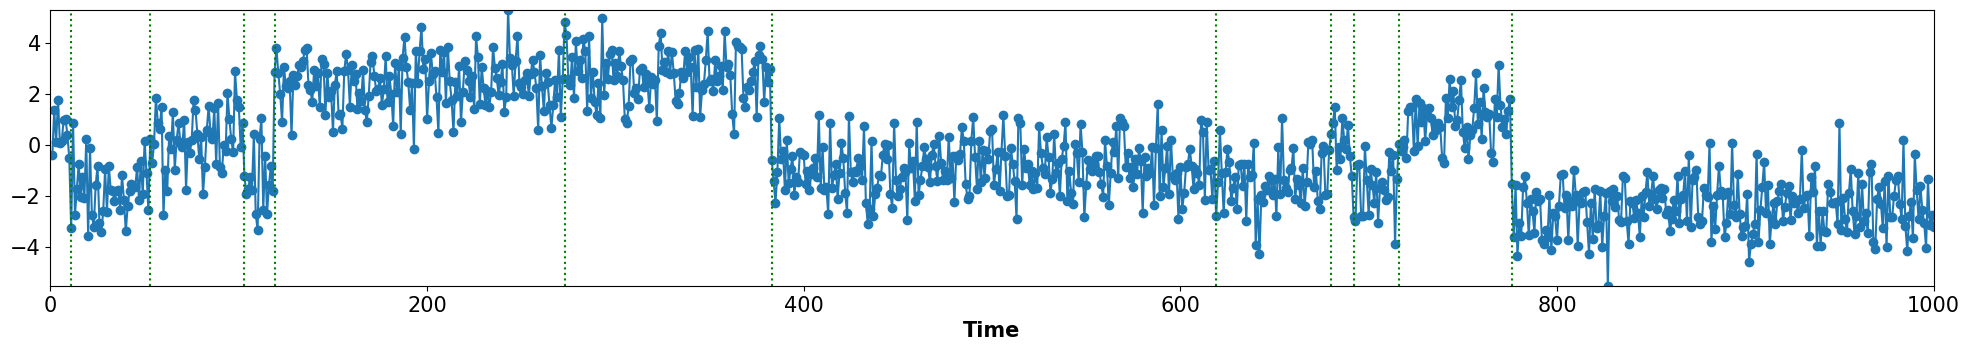

In [4]:
# Plot the data and show changepoint locations
plt, _ = plot_bocd(data, t0=t[0], cps=cps) # type: ignore  # noqa: F811
plt.show()

# Standard BOCD

We pass a time series model to the BOCD algorithm that corresponds to the data generating process decribed above. This demonstrates how effectively the 'standard' BOCD can detect changepoints when the model configuration perfectly matches the data.Also, we assume that there is a changepoint at $t=0$.

In [5]:
p_r0 = np.ones(1, dtype=np.float64) # prior
model = GaussianUnknownMean(mean0, var0, varx)
bocd = BOCD(model, constant_changepoint_prob, p_r0)

Run the algorithm on the batch of data using the convenient method `run_length_posteriors()`. This will compute $p\left(r_{t}\mid x_{1:t}\right)$ for each point in time $t=0,1,...,N$.

In [6]:
prediction_times, _, run_length_posteriors = bocd.run_length_posteriors(data)

Plot the results

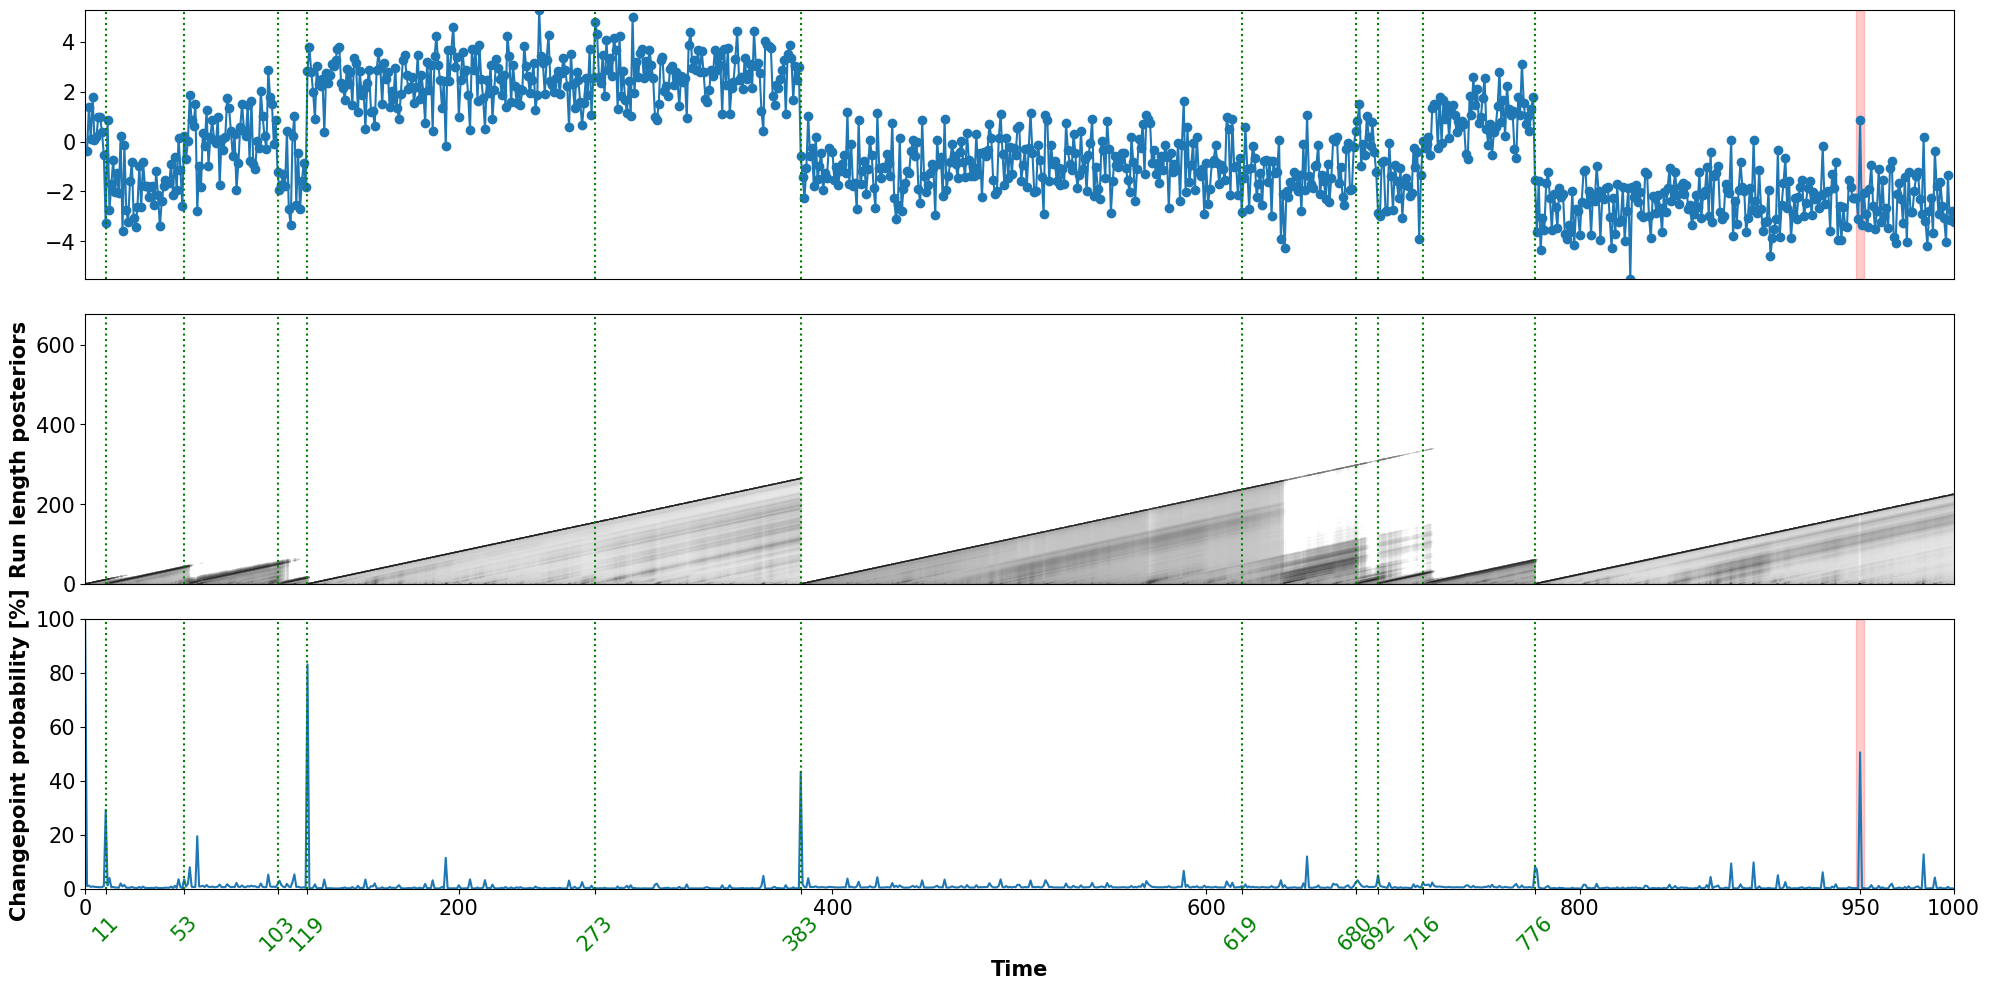

In [7]:
plt, axs = plot_bocd(
    data,
    run_length_posteriors,
    t0=prediction_times[1],
    cps=cps,
    type=PlotType.CHANGEPOINT,
    cp_ticks=True,
) # type: ignore

def add_highlight(ax, poi_x):
    start = poi_x - 2
    end = poi_x + 2
    col = "red"
    ax.add_patch(
        patches.Rectangle(
            (start, ax.get_ylim()[0]),  # Bottom-left corner (x, y)
            end - start,  # Width of the rectangle
            ax.get_ylim()[1] - ax.get_ylim()[0],  # Height of the rectangle
            linewidth=1,
            edgecolor=col,
            facecolor=col,
            alpha=0.2,
            linestyle="-",
        )
    )

poi_x = 950
add_highlight(axs[0], poi_x)
add_highlight(axs[2], poi_x)

axs[-1].set_xticks(list(axs[-1].get_xticks()) + [poi_x])

plt.show()

There are, of course, numerous ways to use the posterior distributions to decide whether a changepoint has occurred. In most example of this notebook, we will simply visually inspect the posterior changepoint probabilities $p\left(r_{t}=0\mid x_{1:t}\right)$, which are displayed in the third row of the figure above.

Some points, such as at $t=199$ and $t=383$ show high confidence of being identified as changepoints by the model. However, there are also a few 'false positives', the most notable one being at $t=950$ (highlighted by a red rectangle), with a changepoint probability of almost 51%:

In [8]:
print(f"p(r_(950) = 0 | x_(1:950)) = {run_length_posteriors[950, 0]*100:.2f}%")

p(r_(950) = 0 | x_(1:950)) = 50.57%


# Look-ahead BOCD

We introduce a lag of $h=1$ in the posterior, which becomes $p\left(r_{t}\mid x_{1:t+1}\right)$ instead of $p\left(r_{t}\mid x_{1:t}\right)$ now. (Note that the implementation can use different values of `h` at different points in time, but in this example we apply constant value for each point in time.) Also, to speed-up computation, a probability threshold is applied, which instructs the algorithm to discard tails with probability mass of less than $1e-4$.

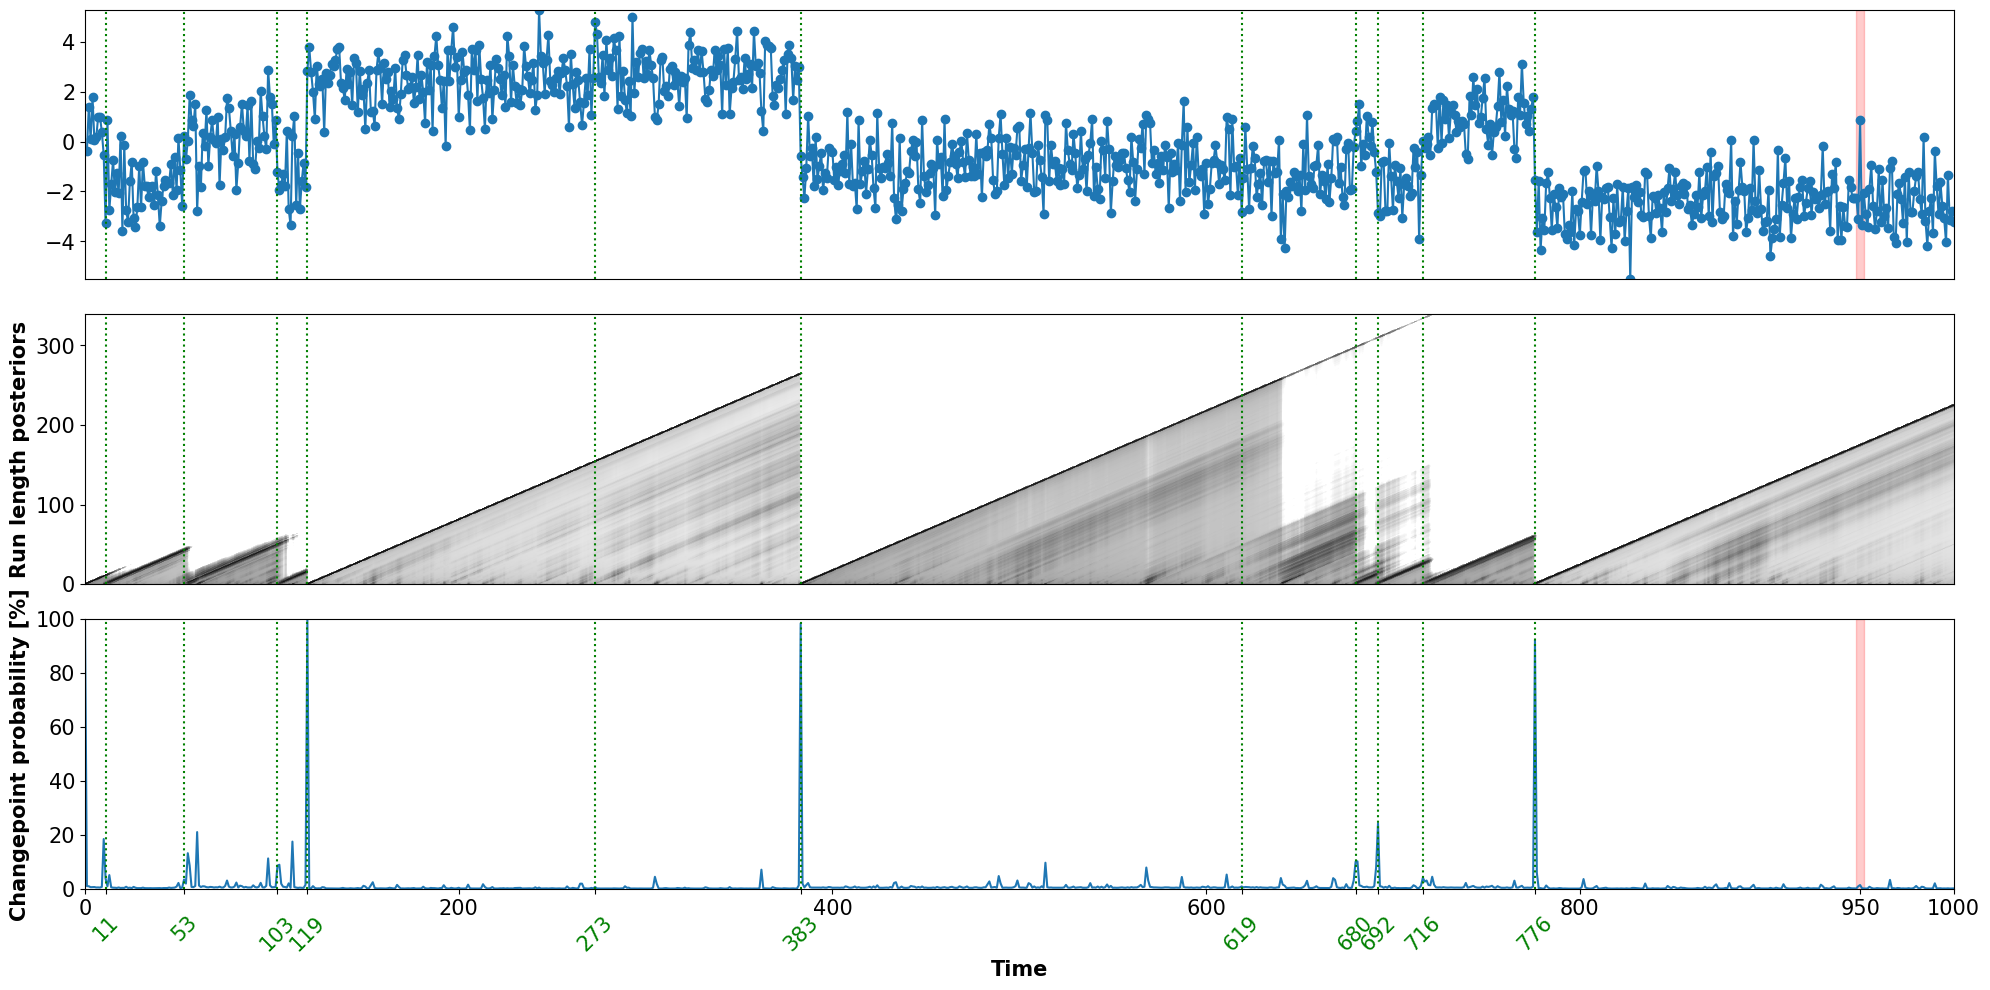

In [9]:
model = GaussianUnknownMean(mean0, var0, varx)
bocd = BOCD(model, constant_changepoint_prob, p_r0, prob_threshold=1e-4)

h = 1

prediction_times, _, run_length_posteriors = bocd.run_length_posteriors(data, h)

# Plot results
plt, axs = plot_bocd(
    data,
    run_length_posteriors,
    t0=prediction_times[1],
    cps=cps,
    cp_ticks=True,
)  # type: ignore

add_highlight(axs[0], poi_x)
add_highlight(axs[2], poi_x)

axs[-1].set_xticks(list(axs[-1].get_xticks()) + [poi_x])

plt.show()

This time, the algorithm favors the option that at time $t=950$ there is just a regular observation rather than a changepoint.

(Note that because we discarded small probabilities, the y-axis of the second subplot showing all posteriors has only about half of the range of the corresponding y-axis in the previous figure.)

Next, we increase $h$ to 5 to see if actual changepoints, such as $t=11$ and $t=680$, can be more confidently detected - which turns out to be the case.

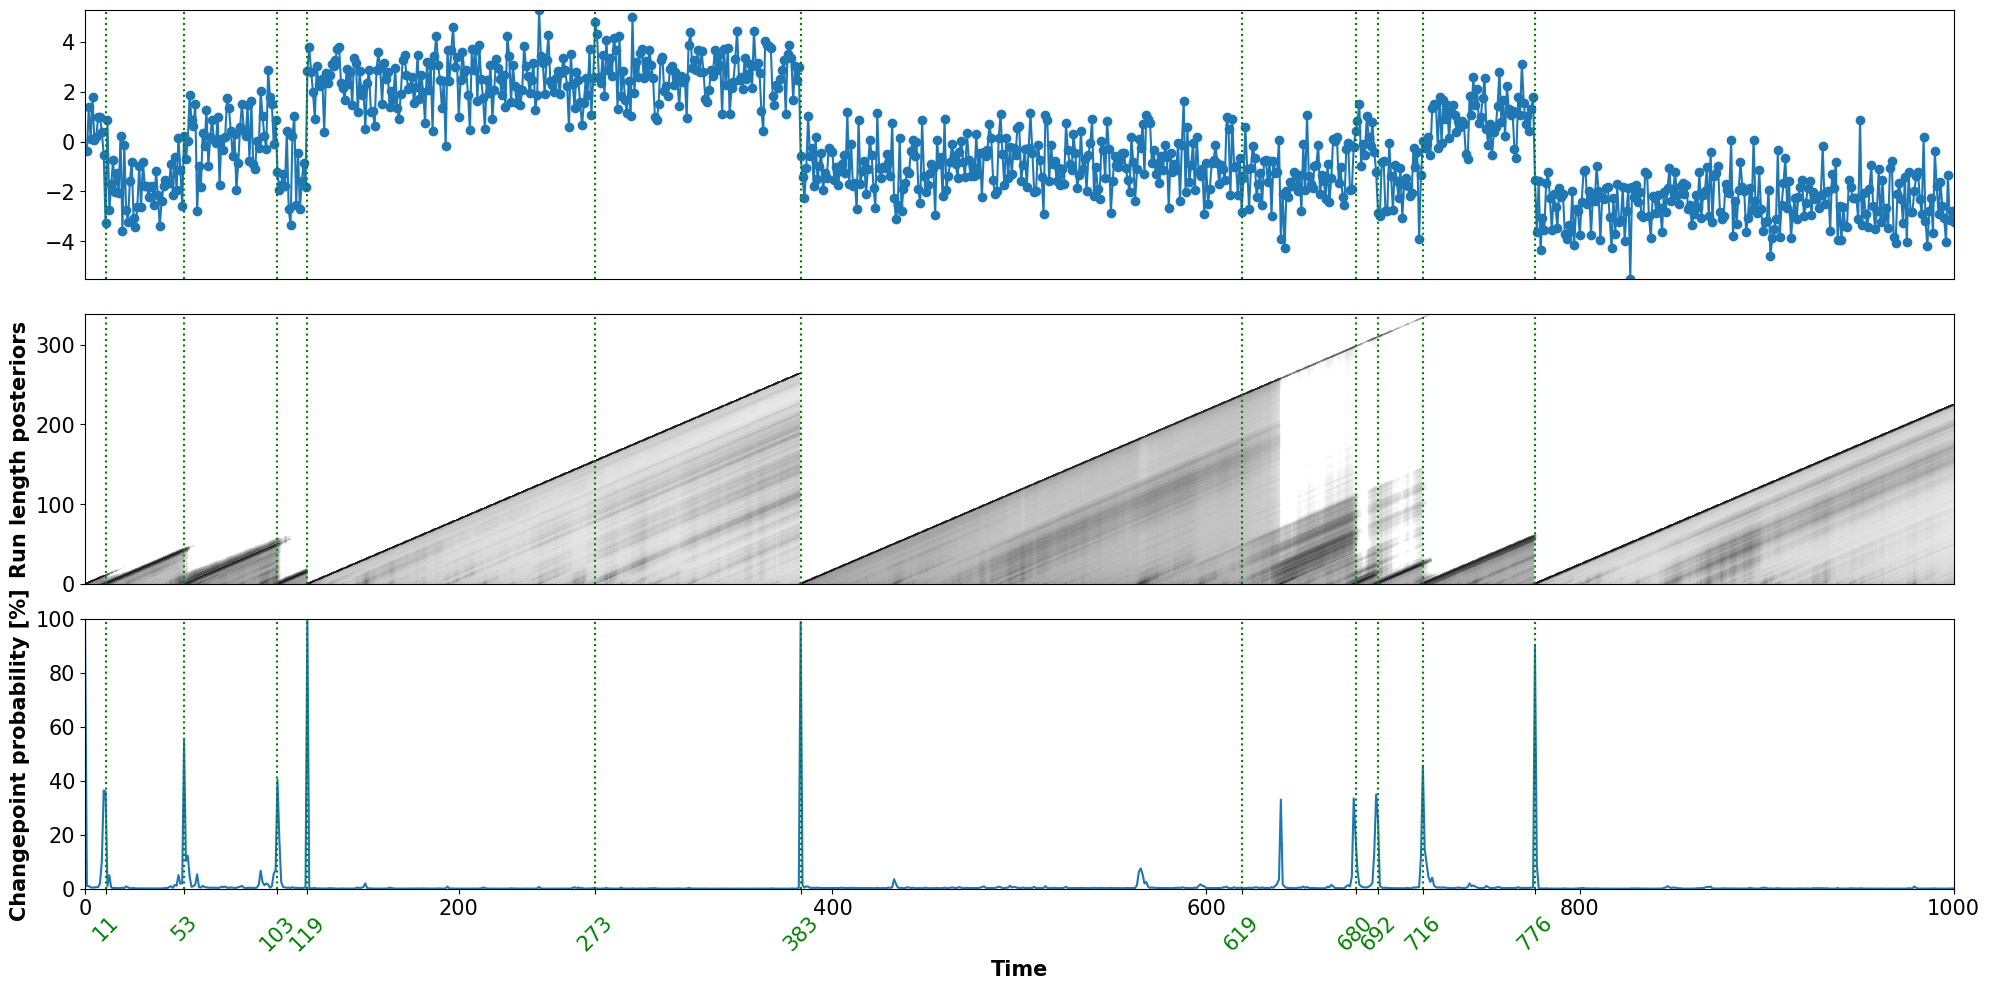

In [10]:
model = GaussianUnknownMean(mean0, var0, varx)
bocd = BOCD(model, constant_changepoint_prob, p_r0, prob_threshold=1e-4)

h = 5

prediction_times, _, run_length_posteriors = bocd.run_length_posteriors(data, h)

plt, axs = plot_bocd(
    data,
    run_length_posteriors,
    t0=prediction_times[1],
    cps=cps,
    cp_ticks=True,
)  # type: ignore


plt.show()

# Custom changepoint transition probability distribution

Instead of using a constant changepoint transition probability $p\left(r_{t}=0\mid r_{t-1}\right)$, we can define an arbitrary distribution, which is even allowed to be time-dependent (though we will not show an example for time-dependence in this notebook).

As stated in Adam and MacKay's paper, the constant ("memoryless") transition probability distribution arises from an exponential geometric distribution for the gap length $g$. Let's use a truncated version of this distribution, such that gap lengths greater than 100 cannot occur: $p_{\mathrm{gap}}\left(g>100\right)=0$. This translates to a transition probability distribution for which $p\left(r_{t}=0\mid r_{t-1}>99\right)=0$, because a previous run length of $r_{t-1}=99$ has to transition into a changepoint at time $t$, as the length of this resulting segment has the maximum possible gap length $g^{\left(\mathrm{max}\right)}=100$.

The transition probabilities which arise from this distribution of gap lengths should be comparable to the "full" memoryless version shown above.

In [11]:
p_r0 = np.ones(1)
g_max = 100
g = np.arange(1, g_max + 1) # gap = 1, ..., 100
gap_probs = (1 - lmbda) ** (g - 1) * lmbda
custom_changepoint_prob = (
    changepoint_probability_distribution_from_gap_probability_distribution(
        gap_probs / gap_probs.sum()
    )
)
assert custom_changepoint_prob(np.array([g_max - 1]), 0) == 1

We continue using $h = 5$, as in the previous example; however, this time there is no need to set a probability threshold to reduce runtime because the changepoint transition probability automatically prevents the run length posterior from growing beyond $r_{t} = 99$.

Also, the implementation automatically discards zero-probability tails.

As can be seen, the results are very  similar to those in the last plot.

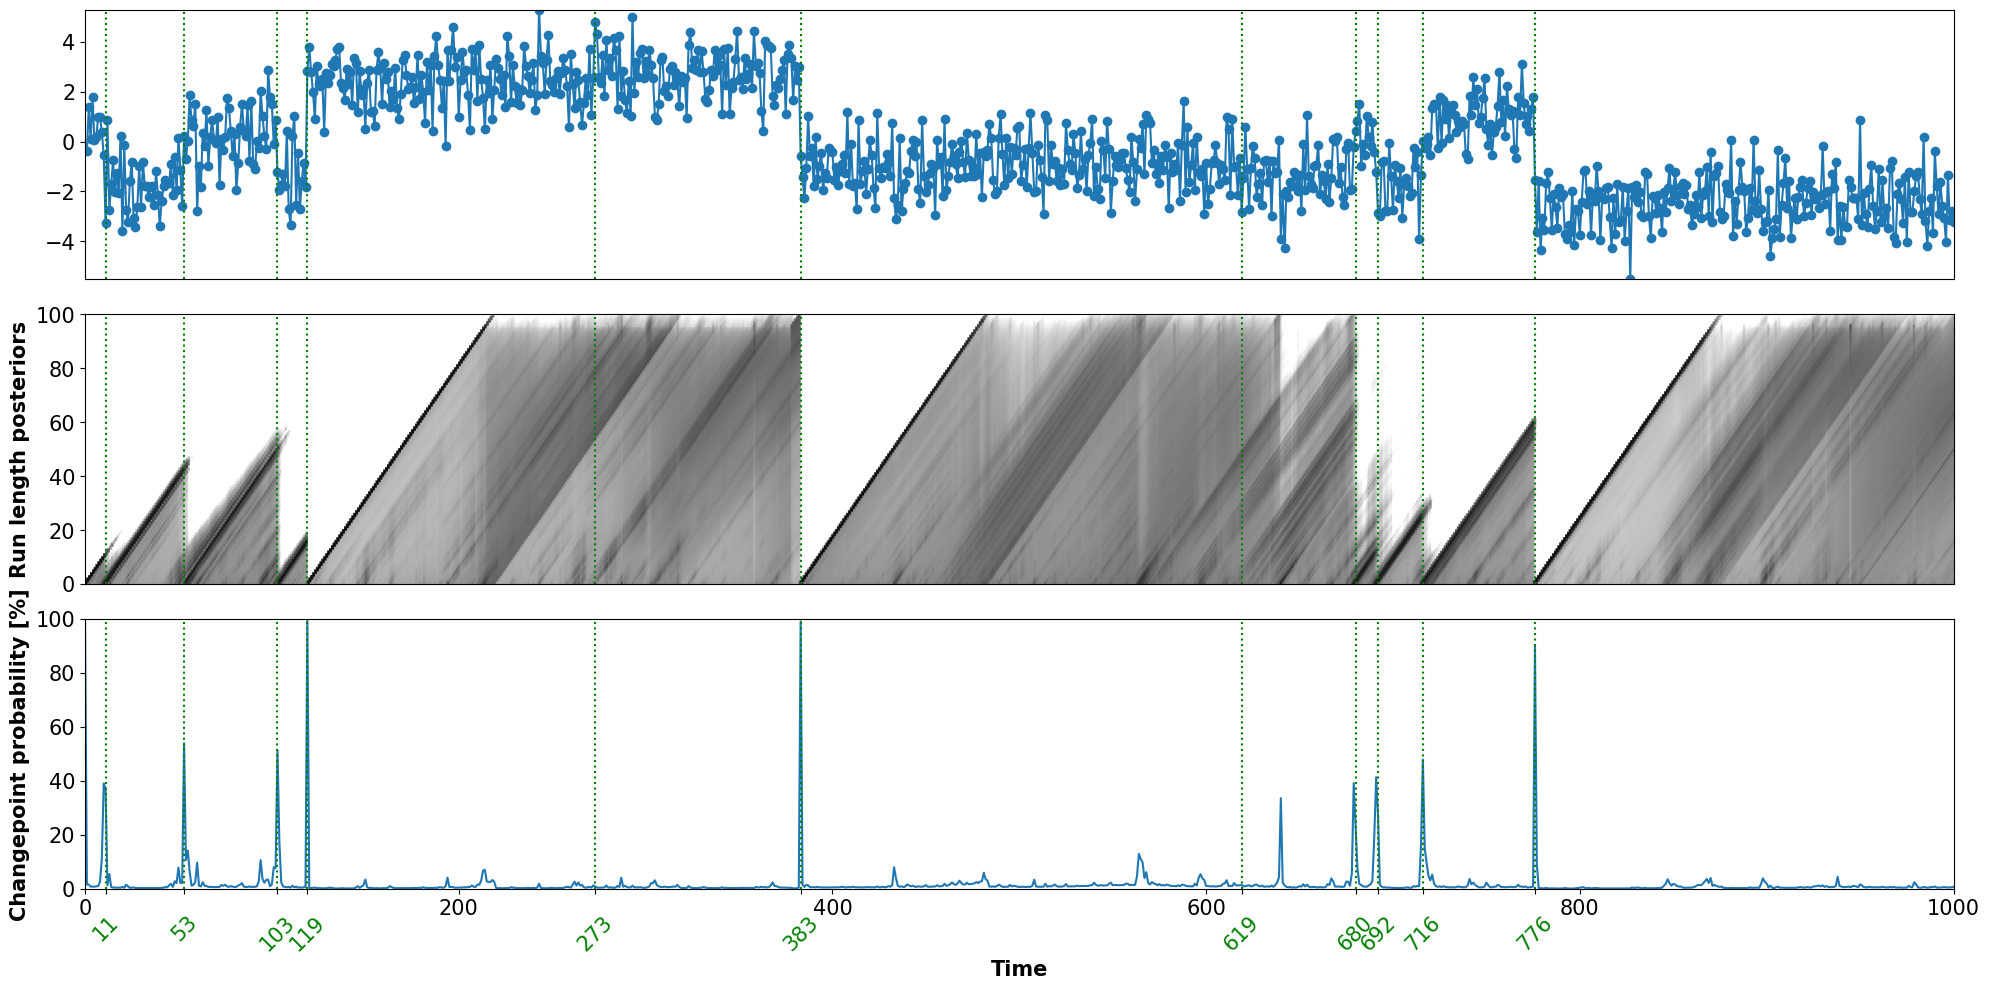

In [12]:
model = GaussianUnknownMean(mean0, var0, varx)
bocd = BOCD(model, custom_changepoint_prob, p_r0)

h = 5

prediction_times, _, run_length_posteriors = bocd.run_length_posteriors(data, h)

plt, axs = plot_bocd(
    data,
    run_length_posteriors,
    t0=prediction_times[1],
    cps=cps,
    cp_ticks=True,
)  # type: ignore


plt.show()

# Dynamic changepoint analysis

Let's assume that BOCD has run up to a certain point in time $t=t'$, for which a detailed changepoint analysis is required and it is technically possible to wait at this point in time, while new observations are collected. We will plot the posterior changepoint probabilities $p\left(r_{t}=0\mid x_{1:t+h}\right)$ as a function of $h=0,1,...$.

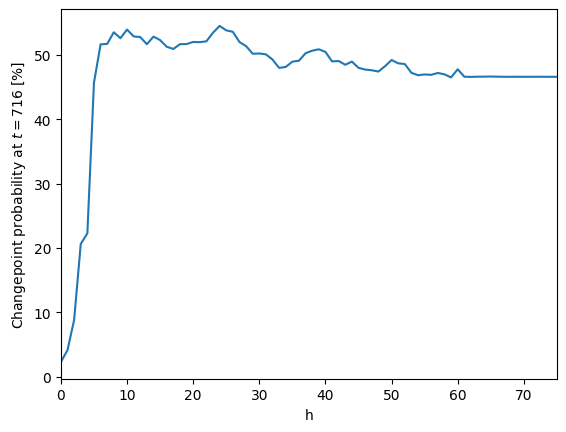

In [13]:
model = GaussianUnknownMean(mean0, var0, varx)
bocd = BOCD(model, constant_changepoint_prob, p_r0, prob_threshold=1e-4)

ts = 716
prediction_times, _, run_length_posteriors = bocd.run_length_posteriors(data[:ts])

# ...Do some analysis with the run length posteriors up to this point in time...

# We are currently at time `ts`. Starting from here, we
# wait for 75 new observations, but we do not step forward in time.

h_max = 75

cp_probs = np.zeros(h_max + 1)
cp_probs[0] = run_length_posteriors[-1, 0]
for h in range(1, h_max + 1):
    bocd.new_observation(data[ts + (h - 1)], step_forward=False)  # `step_forward=False` means we wait at the current point in time
    t, tph, r_post = bocd.run_length_posterior
    cp_probs[h] = r_post[0]
    assert t == ts
    assert tph == ts + h
    
# Plot changepoint probabilities vs h
plt.plot(np.arange(h_max + 1), cp_probs * 100.0)
plt.xlabel("h")
plt.xlim(0, h_max)
plt.ylabel(f"Changepoint probability at $t={ts}$ [%]")
plt.show()

# Custom changepoint prior

So far, we have assumed that at time $t=0$, there is a changepoint, i.e., $p\left(r_{0}=0\right)=1$.

We demonstrate that any prior distribution can be passed to the model, and perform a plausibility check of the implementation by considering two edge cases.

## Alternating changepoints example

Let the prior run length be 4, i.e., $p\left(r_{0}=4\right)=1$. Also, assume that only a gap length of $g=5$ is allowed.

This will give rise to changepoints at times $1, 6, 11, 16, ..., 1 + 5n$ with probability 1 each. 

In [14]:
p_r0 = np.array([0, 0, 0, 0, 1], dtype=np.float64)
gap_probs = np.array([0, 0, 0, 0, 1], dtype=np.float64)
changepoint_prob = (
changepoint_probability_distribution_from_gap_probability_distribution(
    gap_probs / gap_probs.sum()
)
)

model = GaussianUnknownMean(mean0, var0, varx)
bocd = BOCD(model, changepoint_prob, p_r0)

_, _, run_length_posteriors = bocd.run_length_posteriors(data)

cp_mask = 1 + 5*np.arange(run_length_posteriors.shape[0] // 5)
non_cp_mask = np.arange(run_length_posteriors.shape[0])
non_cp_mask[cp_mask] = False

assert np.all(run_length_posteriors[cp_mask, 0] == 1.0)
assert np.all(run_length_posteriors[non_cp_mask, 0] == 0.0)

## No changepoints example

Let the prior run length be 2, i.e., $p\left(r_{0}=2\right)=1$. Also, assume that only a gap length of $g=1$ is allowed.

There can never be a changepoint, because we start at $t=0$ with run length 2, thus falling to $r_{1}=0$ would result in a impossible gap length of $g=3$. This, in turn, requires that $r_{1}=3$ and so on. Therefore, the run length must grow indefinitely over time.

In [15]:
p_r0 = np.array([0, 0, 1], dtype=np.float64)
gap_probs = np.array([1], dtype=np.float64)
changepoint_prob = (
    changepoint_probability_distribution_from_gap_probability_distribution(
        gap_probs / gap_probs.sum()
    )
)

model = GaussianUnknownMean(mean0, var0, varx)
bocd = BOCD(model, changepoint_prob, p_r0)

_, _, run_length_posteriors = bocd.run_length_posteriors(data)

assert np.all(run_length_posteriors[:, 0] == 0.0)